In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate

In [2]:
FPS = 25
last_frame = 6533-1

In [3]:
seq_data = []

for i in range(2):
    seq_data.append(pd.read_csv('Emotion/OneManBand-Seq'+str(i+1)+'.csv', 
                            sep=";", 
                            names=["time","valence","arousal","expression"]))

    seq_data[i] = seq_data[i][seq_data[i].time >=0]

event_file = open('Event/one_man_band_events_filtered.json', 'r')
event_data = json.load(event_file)
event_file.close()

In [4]:
data = {}

data["frame"] = np.ndarray(0)

for i in range(2):
    data["frame"] = np.append(data["frame"], seq_data[i].time.to_numpy()*(FPS))

data["frame"] = np.append(data["frame"], np.arange(0,6533+1,1))
data["frame"].sort()

data["frame"] = np.unique(data["frame"])

n_frame = len(data["frame"])

data["valence"] = []
data["arousal"] = []
data["expression"] = []


for i in range(2):
    df = seq_data[i]

    data["valence"].append(np.ndarray(n_frame))
    data["arousal"].append(np.ndarray(n_frame))
    data["expression"].append(np.ndarray(n_frame, dtype=str))

    line_index = 0

    for j in range(n_frame):
        
        next_line_index = line_index + 1

        if next_line_index == df.shape[0]:
            next_line_index -= 1

        line_row = df.iloc[line_index]
        next_row = df.iloc[next_line_index]

        line_frame = line_row["time"]*FPS
        next_frame = next_row["time"]*FPS

        line_distance = abs(data["frame"][j]-line_frame)
        next_distance = abs(data["frame"][j]-next_frame)

        if line_distance > next_distance:
            line_index += 1

            valence = next_row["valence"]
            arousal = next_row["arousal"]
            expression = next_row["expression"]
        else:
            valence = line_row["valence"]
            arousal = line_row["arousal"]
            expression = line_row["expression"]
        
        
        data["valence"][i][j] = valence
        data["arousal"][i][j] = arousal
        data["expression"][i][j] = expression


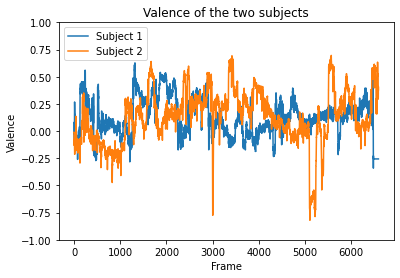

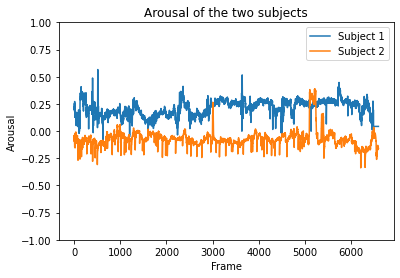

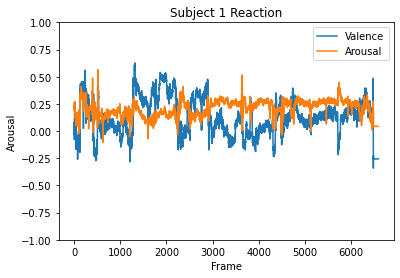

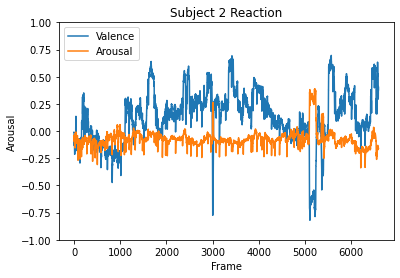

In [140]:
#Valence
fig = plt.figure()
plt.plot(data["frame"], data["valence"][0])
plt.plot(data["frame"], data["valence"][1])
plt.ylim(-1, 1)

plt.legend(["Subject 1", "Subject 2"])
plt.title("Valence of the two subjects")
plt.ylabel("Valence")
plt.xlabel("Frame")

plt.show()
fig.savefig("Results/Valence of the two subjects.png")


#Arousal
fig = plt.figure()
plt.plot(data["frame"], data["arousal"][0])
plt.plot(data["frame"], data["arousal"][1])
plt.ylim(-1, 1)

plt.legend(["Subject 1", "Subject 2"])
plt.title("Arousal of the two subjects")
plt.ylabel("Arousal")
plt.xlabel("Frame")

plt.show()
fig.savefig("Results/Arousal of the two subjects.png")

#Subjects

for i in range(2):
    fig = plt.figure()
    plt.plot(data["frame"], data["valence"][i])
    plt.plot(data["frame"], data["arousal"][i])
    plt.ylim(-1, 1)

    plt.legend(["Valence", "Arousal"])
    plt.title("Subject "+str(i+1)+" Reaction")
    plt.ylabel("Arousal")
    plt.xlabel("Frame")

    plt.show()
    fig.savefig("Results/Subject "+str(i+1)+" Reaction"+".png")


In [139]:
#Correlation

correlation = {}
correlation["Valence between subjects"] = np.corrcoef(data["valence"][0], data["valence"][1])[0][1]
correlation["Arousal between subjects"] = np.corrcoef(data["arousal"][0], data["arousal"][1])[0][1]
correlation["Valence and Arousal of subject 1"] = np.corrcoef(data["arousal"][0], data["valence"][0])[0][1]
correlation["Valence and Arousal of subject 2"] = np.corrcoef(data["arousal"][1], data["valence"][1])[0][1]

print("Correlation")

for key in correlation:
    print(key+":", "{0:.2f}".format(correlation[key]))

correlation_file = open("Results/Correlation.json", "w")
json.dump(correlation, correlation_file)
correlation_file.close()

Correlation
Valence between subjects: 0.00
Arousal between subjects: 0.03
Valence and Arousal of subject 1: -0.06
Valence and Arousal of subject 2: -0.35


In [5]:
data["actor_presence"] = np.zeros((3, n_frame), bool)
data["actor_action"] = np.ndarray((3, n_frame), dtype='<U39')

for i in range(3):
    for j in range(n_frame):
        frame = data["frame"][j]
        if str(int(frame)) in event_data[str(i)] or (str(np.floor(frame)) in event_data[str(i)] and str(np.ceil(frame)) in event_data[str(i)]):
            data["actor_presence"][i][j] = True
            data["actor_action"][i][j] = event_data[str(i)][str(int(frame))]["action"]

In [6]:
data["event"] = {}

actual_event_id = 0

durations = []

for i in range(3):
    start = -1
    end = -1

    for j in range(n_frame):
        if data["actor_presence"][i][j]:
            if start == -1:
                start = j
        else:
            if start != -1:
                end = j

                durations.append(data["frame"][end] - data["frame"][start])

                event = {}
                event["id"] = actual_event_id
                event["start"] = data["frame"][start]
                event["end"] = data["frame"][end]
                event["actor_id"] = i
                event["action"] = data["actor_action"][i][start]
                
                data["event"][actual_event_id] = event

                actual_event_id += 1

                start = -1
    


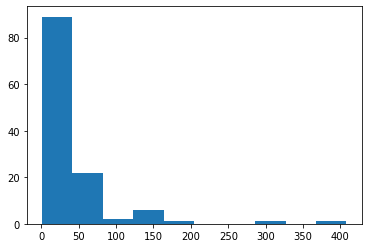

1.00 - 41.70 : 89.0
41.70 - 82.40 : 22.0
82.40 - 123.10 : 2.0
123.10 - 163.80 : 6.0
163.80 - 204.50 : 1.0
204.50 - 245.20 : 0.0
245.20 - 285.90 : 0.0
285.90 - 326.60 : 1.0
326.60 - 367.30 : 0.0
367.30 - 408.00 : 1.0


In [318]:
counts, edges, _ = plt.hist(durations)
plt.show()

for i in range(counts.shape[0]):
    print("{0:.2f}".format(edges[i]), "-", "{0:.2f}".format(edges[i+1]), ":", counts[i])

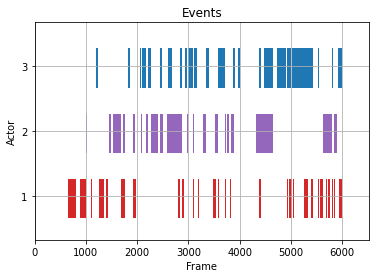

In [321]:
#Plot reference: https://www.geeksforgeeks.org/python-basic-gantt-chart-using-matplotlib/

fig, ax = plt.subplots()

plt.title("Events")

ax.set_xlabel('Frame')
ax.set_ylabel('Actor')

ax.set_ylim(0, 50)
ax.set_xlim(0, last_frame)

ax.set_yticks([10, 25, 40])
ax.set_yticklabels(['1', '2', '3'])
  

ax.grid(True)

for event_id in data["event"]:
    event = data["event"][event_id]
    
    

    if event["actor_id"] == 0:
        line_range = (5,9)
        color = "red"
    elif event["actor_id"] == 1:
        line_range = (20,9)
        color = "purple"
    else:
        line_range = (35,9)
        color = "blue"
    
    start = event["start"]
    duration = event["end"]-start

   
    ax.broken_barh([(start, duration)], line_range, facecolors=('tab:'+color))

plt.show()
fig.savefig("Results/Events.png")


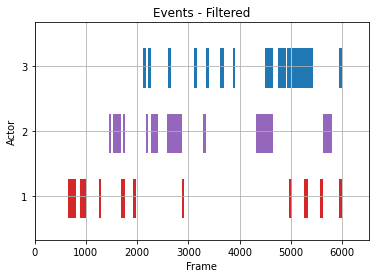

In [7]:
# Filtering events
fig, ax = plt.subplots()

plt.title("Events - Filtered")

ax.set_xlabel('Frame')
ax.set_ylabel('Actor')

ax.set_ylim(0, 50)
ax.set_xlim(0, last_frame)


ax.set_yticks([10, 25, 40])
ax.set_yticklabels(['1', '2', '3'])
  

ax.grid(True)

text_up = [False, False, False]

for event_id in list(data["event"].keys()):
    event = data["event"][event_id]
    
    

    if event["actor_id"] == 0:
        line_range = (5,9)
        color = "red"
    elif event["actor_id"] == 1:
        line_range = (20,9)
        color = "purple"
    else:
        line_range = (35,9)
        color = "blue"
    
    start = event["start"]
    duration = event["end"]-start

    if duration > 40:
        ax.broken_barh([(start, duration)], line_range, facecolors=('tab:'+color))

        text_position = line_range[0]-2.5

        if text_up[event["actor_id"]]:
            text_position += 10

        #plt.text(start+(duration/2), text_position, event["action"][0], rotation=0, size=10)
        
        text_up[event["actor_id"]] = not text_up[event["actor_id"]]
    else:
        del data["event"][event_id]

plt.show()
fig.savefig("Results/Events - Filtered.png")

In [13]:
def event_reaction(event_id, subject):
    start = data["event"][event_id]["start"]
    end = data["event"][event_id]["end"]

    mask = np.logical_and(data["frame"]>=start, data["frame"]<=end)
    
    frames = data["frame"][mask]
    valence = data["valence"][subject][mask]
    #valence = smoothed[mask]
    arousal = data["arousal"][subject][mask]

    valence_reaction = integrate.simps(valence, frames)/(end-start)
    arousal_reaction = integrate.simps(arousal, frames)/(end-start)

    return valence_reaction, arousal_reaction

subject = 1
valence2 = []
arousal = []

for event_id in data["event"]:
    valence_reaction, arousal_reaction = event_reaction(event_id, subject)

    valence2.append(valence_reaction)
    arousal.append(arousal_reaction)


In [10]:
valence

[-0.19914663471091887,
 -0.22764858470458227,
 0.05477745846065831,
 0.3862564175080672,
 0.1208375129500852,
 0.49454680968250175,
 0.016241929006663887,
 0.10379609932422076,
 0.5607010090087721,
 0.30152208354968874,
 0.15015834850966087,
 0.129187646717813,
 0.5287832746868977,
 0.29917665465596144,
 0.1756414007652063,
 0.28929700446706647,
 0.2699232133217415,
 0.262024936544825,
 0.23990680464725017,
 0.05803135226035466,
 0.21440259077633214,
 0.1356899221806494,
 0.1598516088064828,
 0.28481199254696404,
 0.18140923962720648,
 0.6064924409626907,
 0.21218909901731173,
 0.37718931536348943,
 0.03009160110138395,
 -0.029067253317506855,
 0.027552374014237838,
 -0.25843701095685706,
 0.30152208354968874]

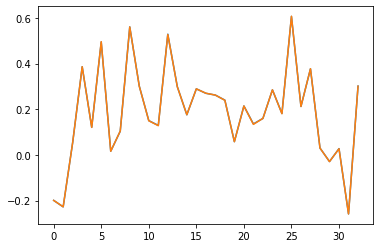

In [14]:
plt.plot(valence)
plt.plot(valence2)

In [8]:
smoothed = np.zeros(data["valence"][1].shape[0])

sigma = 2

for i in range(data["frame"].shape[0]):
    frame = data["frame"][i]

    min_index = min(i-10, 0)
    max_index = max(i+10, n_frame-1)

    kernel = np.exp(-np.power((data['frame']-frame), 2)/(2*np.power(sigma, 2)))
    kernel = kernel / sum(kernel)

    smoothed[i] = np.sum(data["valence"][1] * kernel)



In [407]:
data["frame"].shape[0]

22127

In [412]:
smoothed

array([ 0.01980476,  0.0196307 ,  0.01073531, ..., -0.2561309 ,
       -0.2561309 , -0.2561309 ])

In [382]:
%matplotlib qt

plt.plot(data["frame"], data["valence"][0], linewidth=1)
plt.plot(data["frame"], smoothed2, linewidth=1)

plt.show()

In [364]:
np.argmax(valence)

25

In [365]:
list(data["event"].keys())[25]

98

In [366]:
print(data["event"][98]["start"], data["event"][98]["end"])

3347.0 3407.0


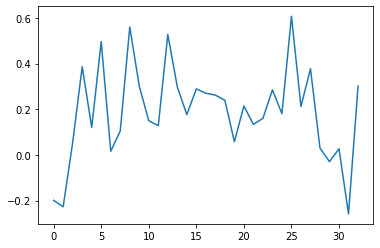

In [350]:
plt.plot(valence)

In [356]:
for event_id in data["event"]:
    if data["event"][event_id]["start"]>= 5075 and data["event"][event_id]["end"] <= 5750:
        print(event_id)

39
42


In [360]:
event_reaction(42, 1)

(0.5604684750607789, -0.019832117345507508)

In [368]:
def encoder(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    
    return obj.__dict__

result_file = open("Results/result.json", "w")
json.dump(data, result_file,  default=lambda o: encoder(o))
result_file.close()